# Imports

In [22]:
# Usual stuff
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Typing
from typing import Callable

In [23]:
# Sympy pretty printing
sp.init_printing()

# Hamiltonian

We construct a matrix for the following Hamiltonian:

$$
\begin{align*}

H^\text{MF} &= \sum_{\textbf k > 0} H_{\textbf k}

\end{align*}
$$

Where:

- $H_\textbf k$ couples only the $\pm\textbf k$ modes:
    
    $$
    \begin{align*}
    
    H_{\textbf k} &= \xi_\textbf k(\hat n_\textbf k + \hat n_{-\textbf k}) + U(\hat n_{\textbf k\uarr}\hat n_{\textbf k\darr} + \hat n_{-\textbf k\uarr}\hat n_{-\textbf k \darr})
    \\[0.2cm]
    
    &\quad +\Delta^*(b_\textbf k + b_{-\textbf k}) + \Delta(b_\textbf k^\dag + b_{-\textbf k}^\dag)
    
    \end{align*}
    $$
    
- $\Delta$ has to be solved self-consistently for:
    
    $$
    \begin{align*}
    
    \Delta &= -\frac{g}{L_d}\sum_\textbf k\lang b_\textbf k\rang
    
    \end{align*}
    $$

- $b_\textbf k$ is the pair operator for $s$-wave coupling:
    
    $$
    \begin{align*}
    
    b_\textbf k &= c_{-\textbf k\darr}c_{\textbf k\uarr}
    \\[0.2cm]

    b_\textbf k^\dag &= c_{\textbf k\uarr}^\dag c_{-\textbf k\darr}^\dag
    
    \end{align*}
    $$

We write the Hamiltonian as follows, were the states can be read as binary numbers:
$$
\begin{align*}

H_{\textbf k} &= \sum_{n_{\pm\textbf k, \pm\sigma} = 0}^1\sum_{n'_{\pm\textbf k, \pm\sigma} = 0}^1 \lang n_{\textbf k \uarr}n_{\textbf k \darr}n_{-\textbf k \uarr}n_{-\textbf k \darr} \mid H_{\textbf k}  \mid n'_{\textbf k \uarr}n'_{\textbf k \darr}n'_{-\textbf k \uarr}n'_{-\textbf k \darr} \rang 
\ket{n_{\textbf k \uarr}n_{\textbf k \darr}n_{-\textbf k \uarr}n_{-\textbf k \darr}} \bra{n'_{\textbf k \uarr}n'_{\textbf k \darr}n'_{-\textbf k \uarr}n'_{-\textbf k \darr} }

\end{align*}
$$

In [24]:
def eps(kk: np.ndarray) -> np.ndarray:
    """
        Compute the dispersion relation for a given set of vectors `kk`.
    """
    return -2 * np.sum(np.cos(kk), axis = 0)


def fock(decimal: int) -> list[int]:
    string = f"{bin(decimal)[2:]:0>4}"
    nks = list(map(int, list(string)))
    return nks


def bpair():
    """
        Create the matrix representation for bk.
    """

    # Dimension of the Fock space
    dim = 16
    
    # Build the operator
    bk = np.zeros((dim, dim), dtype=np.float64)

    # Matrix elements
    for i in range(dim):
        for j in range(dim):
            npkui, npkdi, nmkui, nmkdi = fock(i)
            npkuj, npkdj, nmkuj, nmkdj = fock(j)

            bk[i, j] += (-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (npkdi == npkdj) * (nmkui == nmkuj)
    
    return bk


def ntotal():
    """
        Create the matrix representation for number operators.
    """

    # Dimension of the Fock space
    dim = 16
    
    # Build the operators
    npk = np.zeros((dim, dim), dtype=np.float64)
    nmk = np.zeros((dim, dim), dtype=np.float64)
    ntk = np.zeros((dim, dim), dtype=np.float64)

    # Matrix elements
    for i in range(dim):
        npku, npkd, nmku, nmkd = fock(i)
        npk[i, i] += npku + npkd
        nmk[i, i] += nmku + nmkd
    
    # Total number of electrons
    ntk = npk + nmk

    return ntk, npk, nmk


def ham(kk: np.ndarray, U: float, mu: float, Delta: complex):
    """
        Create the Hamiltonian Hk numerically.
    """

    # Dimension of the Fock space
    dim = 16

    # Number of k-points
    Nk = len(kk[0])

    # Dispersion relation
    xi = eps(kk) - mu

    # Build the Hamiltonian
    Hk = np.zeros((Nk, dim, dim), dtype=np.float64)
    
    # Diagonal terms
    for i in range(dim):
        npku, npkd, nmku, nmkd = fock(i)
        Hk[:, i, i] += xi * (npku + npkd + nmku + nmkd)
        Hk[:, i, i] += U * (npku * npkd + nmku * nmkd)
    
    # Off-diagonal terms, taking into account the phase factor!
    # I will do only the destruction terms, as the creation ones are obtained by conjugation.
    for i in range(dim):
        npkui, npkdi, nmkui, nmkdi = fock(i)

        if npkui * nmkdi:
            Hk[:, i - 8 - 1, i] += Delta.conjugate() * (-1)**(npkdi + nmkui)
        
        if npkdi * nmkui:
            Hk[:, i - 4 - 2, i] += Delta.conjugate() * (-1)**(npkdi)

    # for i in range(dim):
    #     for j in range(dim):
    #         npkui, npkdi, nmkui, nmkdi = fock(i)
    #         npkuj, npkdj, nmkuj, nmkdj = fock(j)

    #         Hk[:, i, j] += Delta.conjugate() * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (npkdi == npkdj) * (nmkui == nmkuj) + 
    #                                             (-1)**(npkdj) * ((nmkui + 1) == nmkuj) * ((npkdi + 1) == npkdj) * (npkui == npkuj) * (nmkdi == nmkdj))
    
    # Hermitian conjugate
    for i in range(dim):
        for j in range(dim):
            if i != j and Hk[0, j, i] == 0:
                Hk[:, j, i] += np.conjugate(Hk[:, i, j])
    
    return Hk


def thermal_average(vals: np.ndarray, vecs: np.ndarray, op: np.ndarray, T: float, dim: int):

    # Minimum energy, to scale Boltzmann factors
    E0 = np.min(vals, axis=1)
    E0 = np.tile(E0[:, None], (1, dim))
    vals = vals - E0

    # Boltzmann exponential
    bexp = np.exp(-vals/T)

    # Compute partition function (sum over all dim states for each k)
    Z = np.sum(bexp, axis = 1)
    Z = np.tile(Z[:, None], (1, dim))

    # Compute Boltzmann factor
    bfac = bexp / Z
    
    # Compute average via a trace
    res = 0

    for id in range(dim):
        # Build bra and ket
        bra = vecs[:, :, id]
        ket = bra.T
        bra = np.conjugate(ket)
        
        # Compute average (sum over axis=0 is expectation value, sum over axis=1 is over various k-points)
        res += np.sum(bfac[:, id] * bra * (op @ ket))

    return res

## Solving the Hamiltonian

In [25]:
def solve(L: int, d: int, U: float, mu: float, g: float, T: float, delta_start: float = 1e-3, delta_eps: float = 1e-4):
    """
        Solve the mean-field Hamiltonian for `L` k-points along each `d` directions for temperature `T` and chemical potential `mu`.

        Self-consistently compute Delta starting at `delta_start` with an error of `delta_eps`.
    """

    # Dimension of the Fock space
    dim = 16

    # Possible adjustments
    # Take out the [:-1] from kk
    # Change the kx > 0 into kx >= 0


    # OBTAINING K-POINTS

    # Determine values of k in our lattice
    kk = np.linspace(-np.pi, np.pi, L + 1)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (d, L ** d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d)

    # Select only kx > 0
    mesh_kk = mesh_kk[:, mesh_kk[0] > 0]

    # Number of k-points
    Nk = len(mesh_kk[0])


    # OPERATORS TO AVERAGE

    # Matrix for b
    bk = bpair()

    # Matrix for n
    ntk, npk, nmk = ntotal()


    # SELF-CONSISTENT CALCULATION OF DELTA

    delta_error = delta_eps + 1
    while delta_error > delta_eps:

        # Get the Hamiltonians, which has size (Nk, dim, dim)
        Hk = ham(mesh_kk, U, mu, delta_start)

        # Debug: Print the Hamiltonian
        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(Hk)
        #     print(f"This is Hermitian! {(Hk == Hk.conj().transpose(0, 2, 1)).all()}")

        # Diagonalize Hamiltonians
        vals, vecs = np.linalg.eigh(Hk)

        # Note: Changing the normalization to 2*Nk instead of Nk gives the wrong result
        delta_new = -g * thermal_average(vals, vecs, bk, T, dim) / Nk

        # Compute error
        delta_error = np.abs(delta_start - delta_new)

        # Prepare next loop
        delta_start = delta_new
    

    # SOLVE FOR CONVERGED DELTA

    # Get the Hamiltonian, which has size (Nk, dim, dim)
    Hk = ham(mesh_kk, U, mu, delta_start)
    
    # Diagonalize Hamiltonians
    vals, vecs = np.linalg.eigh(Hk)

    # Debug: See the eigenstates
    # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
    #     print(vecs)
    #     print(vals)
    #     print(np.exp(-vals/T))
    
    # Minimum energy, to scale Boltzmann factors
    E0 = np.min(vals, axis=1)
    E0 = np.tile(E0[:, None], (1, dim))
    vals = vals - E0

    # Boltzmann exponential
    bexp = np.exp(-vals/T)

    # Compute partition function (sum over all dim states for each k)
    Z = np.sum(bexp, axis = 1)
    Z = np.tile(Z[:, None], (1, dim))

    # Compute Boltzmann factor
    bfac = bexp / Z
    
    # Compute observables
    n = 0
    Jx = 0
    Kxx = 0
    for index_n in range(dim):
        # Build bra and ket
        bra = vecs[:, :, index_n]
        ket = bra.T
        bra = np.conjugate(ket)

        # Average number of electrons
        n += np.sum(bfac[:, index_n] * bra * (ntk @ ket))
        
        # Second derivative of eps along kx
        epsxx = 2 * np.cos(mesh_kk[0, :])
        
        # Compute average (sum over axis=0 is expectation value, sum over axis=1 is over various k-points)
        Kxx += np.sum(bfac[:, index_n] * epsxx * bra * (ntk @ ket))


    
        for index_m in range(dim):

            # Skip diagonal
            if index_n == index_m:
                continue

            # First derivative of eps along kx
            epsx = 2 * np.sin(mesh_kk[0, :])
            
            # States with different energies
            mask = np.abs(vals[:, index_n] - vals[:, index_m]) > 0
            
            # Build bra and ket
            bra = np.conjugate(vecs[:, :, index_n].T)
            ket = vecs[:, :, index_m].T

            # Compute average (sum over axis=0 is expectation value, sum over axis=1 is over various k-points)
            # On the first line we are computing the +k and on the second the -k
            Jx += np.sum((epsx * np.abs(bra * (npk @ ket))**2)[:, mask] * (bfac[mask, index_m] - bfac[mask, index_n]) / (vals[mask, index_n] - vals[mask, index_m]))
            Jx += np.sum((-epsx * np.abs(bra * (nmk @ ket))**2)[:, mask] * (bfac[mask, index_m] - bfac[mask, index_n]) / (vals[mask, index_n] - vals[mask, index_m]))

    
    # Normalize
    n = n / (2*Nk)
    Jx = np.pi / (L ** d) * Jx
    Kxx = np.pi / (L ** d) * Kxx

    # Take the real part in case something is complex
    n = np.real(n)
    Jx = np.real(Jx)
    Kxx = np.real(Kxx)


    return delta_start, n, Kxx, Jx

In [26]:
# PARAMETERS
L = 1000
d = 1
U = 1
mu = 0.5
g = 1.5
T = 0.01

# Example CALCULATION
Delta, n, Kxx, Jx = solve(L, d, U, mu, g, T)

## Phillips Plot

In [ ]:
# PARAMETERS
L = 1000
d = 1
T = 0.01


# g SWEEP
gg = [0.0, 3.0]

# U SWEEP
uu = [0.0, 12.0]

# Calculations
for U in uu:
    for g in gg:

        # MU SWEEP
        mu_start = -2*d - U - g
        mu_end = -mu_start
        mu_steps = 50

        mm = np.linspace(mu_start, mu_end, mu_steps+1)

        nn = []
        ss = []
        for mu in mm:

            # Solve the Hamiltonian
            Delta, n, Kxx, Jx = solve(L, d, U, mu, g, T)

            # Save the filling
            nn += [n]

            # Debugging:
            # print(f"For U = {U: <4.1f}, g = {g: <4.1f} and mu = {mu: <6.2f} we have n = {n: <7.3f} Kxx = {Kxx: <9.5f} Jx = {Jx: <9.5f} and vals in range [{np.min(vals): <9.5f}, {np.max(vals): <9.5f}]")

            # Save the superfluid stifness
            ss += [Kxx - Jx]

            # TODO: This gives Jx = 0, maybe there is a bug?
            # print(f"Value of Jx/Kxx: {Jx/Kxx:.6e}")
            
        plt.plot(nn, ss, label=f"U = {U} and g = {g}")

plt.title(f"Filling (L = {L}, d = {d}, T = {T})")
plt.xlabel("Filling")
plt.ylabel("Superfluid stifness")
plt.legend(bbox_to_anchor=(1.1, 1.05))

Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of Jx/Kxx: 0.000000e+00
Value of J

KeyboardInterrupt: 

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

In [ ]:
# # PARAMETERS
# L = 1000
# d = 1
# U = 0
# g = 0.1
# T = 0.01


# # MU SWEEP
# mu_start = -2*d - U
# mu_steps = 30
# mu_eps = 0.1

# # Find new mu_start
# mu_error = 1
# while mu_error > mu_eps:
#     # Solve the Hamiltonian
#     Delta, n, Kxx, Jx, vals = solve(L, d, U, mu_start, g, T)

#     print(f"For U = {U: <4.1f}, g = {g: <4.1f} and mu = {mu_start: <6.2f} we have n = {n: <7.3f} Kxx = {Kxx: <9.5f} Jx = {Jx: <9.5f} and vals in range [{np.min(vals): <9.5f}, {np.max(vals): <9.5f}]")

#     # Compare range of energies with chosen mu (divide each eigenvalue per 4 particles and then shift by 1/2)
#     mu_new = -0.5 * np.real(np.max(vals) / 4)

#     # Compute error and prepare next iteration
#     mu_error = np.abs(mu_start - mu_new)
#     mu_start = mu_new


# print(f"Converged for mu = {mu_start:.4f}")


# # Calculations
# mm = np.linspace(mu_start, -mu_start, mu_steps+1)
# nn = []
# for mu in mm:

#     # Solve the Hamiltonian
#     Delta, n, Kxx, Jx, vals = solve(L, d, U, mu, g, T)
    
#     # Save the filling
#     nn += [n]

# plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, T = {T})")
# plt.ylabel("Filling")
# plt.xlabel("Chemical Potential / t")
# plt.plot(mm, nn, label="Calculations")
# plt.plot(mm, (2 / np.pi) * np.arccos(-0.5 * mm), label="Theory")
# plt.legend()

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

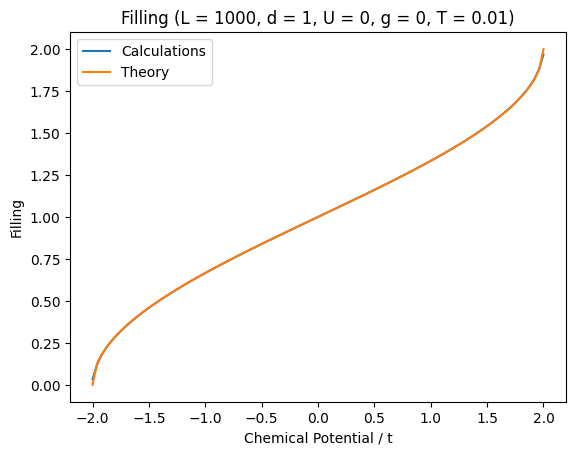

In [ ]:
# PARAMETERS
L = 1000
d = 1
U = 0
g = 0
T = 0.01


# MU SWEEP
mu_start = -2*d - U
mu_end = -mu_start
mu_steps = int(L/10)


# Calculations
mm = np.linspace(mu_start, mu_end, mu_steps+1)
nn = []
for mu in mm:

    # Solve the Hamiltonian
    Delta, n, Kxx, Jx = solve(L, d, U, mu, g, T)

    # Save the filling
    nn += [n]

plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, T = {T})")
plt.ylabel("Filling")
plt.xlabel("Chemical Potential / t")
plt.plot(mm, nn, label="Calculations")
plt.plot(mm, (2 / np.pi) * np.arccos(-0.5 * mm), label="Theory")
plt.legend()

## Previous Attempt - Hamiltonian with SymPy

In [ ]:
'''
# We are using the notation npku as "n plus k up"
def ham():
    """
        Create the Hamiltonian Hk symbolically.
    """

    # Dimension of the Fock space
    dim = 16

    # Build the Hamiltonian
    Hk = sp.zeros(dim, dim)

    # Symbols
    xi, U, Delta = sp.symbols("xi, U, Delta")
    Delta_star = sp.conjugate(Delta)
    
    # Diagonal terms
    for i in range(dim):
        npku, npkd, nmku, nmkd = fock(i)
        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)
        Hk[i, i] += U * (npku * npkd + nmku * nmkd)
    
    # Off-diagonal terms, taking into account the phase factor!
    # I will do only the destruction terms, as the creation ones are obtained by conjugation.
    for i in range(dim):
        for j in range(dim):
            npkui, npkdi, nmkui, nmkdi = fock(i)
            npkuj, npkdj, nmkuj, nmkdj = fock(j)

            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (npkdi == npkdj) * (nmkui == nmkuj) + 
                                      (-1)**(npkdj) * ((nmkui + 1) == nmkuj) * ((npkdi + 1) == npkdj) * (npkui == npkuj) * (nmkdi == nmkdj))
    
    # Hermitian conjugate
    for i in range(dim):
        for j in range(dim):
            if i != j and Hk[j, i] == 0:
                Hk[j, i] += sp.conjugate(Hk[i, j])
    
    return Hk


def solve(N: int, d: int, U: float, mu: float):
    """
        Solve the mean-field Hamiltonian for N k-points along each d directions.
    """

    # Get the Hamiltonian
    Hk = ham()

    print("Hamiltonian:")
    print(sp.latex(Hk))

    # Diagonalize the Hamiltonian
    (vecs, vals) = Hk.diagonalize(sort=True, normalize=True)

    print("\nEigenvectors:")
    print(sp.latex(vecs))
    print(sp.latex(vals))

    print("\nEigenvectors in string form:")
    print(str(vecs))
    print(str(vals))

'''

'\n# We are using the notation npku as "n plus k up"\ndef ham():\n    """\n        Create the Hamiltonian Hk symbolically.\n    """\n\n    # Dimension of the Fock space\n    dim = 16\n\n    # Build the Hamiltonian\n    Hk = sp.zeros(dim, dim)\n\n    # Symbols\n    xi, U, Delta = sp.symbols("xi, U, Delta")\n    Delta_star = sp.conjugate(Delta)\n    \n    # Diagonal terms\n    for i in range(dim):\n        npku, npkd, nmku, nmkd = fock(i)\n        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)\n        Hk[i, i] += U * (npku * npkd + nmku * nmkd)\n    \n    # Off-diagonal terms, taking into account the phase factor!\n    # I will do only the destruction terms, as the creation ones are obtained by conjugation.\n    for i in range(dim):\n        for j in range(dim):\n            npkui, npkdi, nmkui, nmkdi = fock(i)\n            npkuj, npkdj, nmkuj, nmkdj = fock(j)\n\n            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (np

Result:

$$
\left[\begin{array}{cccccccccccccccc}0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0\\0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0\\0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0\\0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\- \Delta & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \overline{\Delta}\\0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0\\\Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta}\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0\\0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0\\0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0\\0 & 0 & 0 & 0 & 0 & 0 & \Delta & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 2 U + 4 \xi\end{array}\right]
$$